# Anomaly detection - HTTP requests - CSIC dataset 2010

## Task
The primary objective is to develop a classifier capable of identifying malicious HTTP requests by training on normal traffic data and evaluating both normal and anomalous test data. The dataset is structured as follows:

 * Normal Traffic (Train)
 * Normal Traffic (Test)
 * Anomalous Traffic (Test)

Although the dataset is designed for unsupervised learning, supervised learning techniques can be applied by combining normal and anomalous data into a labeled dataset. This allows for direct classification using any preferred machine learning model.

## Dataset
The dataset contains the generated traffic targeted to an e-commerce web
application. It is an automatically generated dataset that contains 36,000 normal
requests and more than 25,000 anomalous requests (i.e., web attacks).

### 0. Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
import re
from sklearn.preprocessing import LabelEncoder

### 1. Data Load and Preparation

Data Preprocessing:

* Combine HTTP method, URL, version, user-agent, and body into a single text feature

* Perform basic text cleaning (lowercasing, removing special characters)

Feature Extraction:

* Use TF-IDF with n-grams (1-2 words) to convert text to numerical features

* Limit to top 1000 features to manage dimensionality

In [9]:
def preprocess_data(df):
    """Preprocess the HTTP request data"""
    # Combine relevant features into a single text feature
    df['text'] = df['Method'] + ' ' + df['URL'] + ' ' + df['HTTP_Version'] + ' ' + df['User-Agent']
    
    # Add body content if exists
    df['text'] = df.apply(lambda x: x['text'] + ' ' + str(x['Body']) if pd.notna(x['Body']) else x['text'], axis=1)
    
    # Basic text cleaning
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower()))
    
    return df

def load_and_prepare_data(filepath):
    """Load and prepare the dataset"""
    df = pd.read_csv(filepath)
    
    # Preprocess the data
    df = preprocess_data(df)
    
    # Encode labels (Normal=0, Anomalous=1)
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['Normal_Anom'])
    
    # Extract features and labels
    X = df['text']
    y = df['label']
    
    return X, y, le

### 2. Model Training

* We'll use Random Forest classifier which works well with text data

In [10]:
def train_model(X_train, y_train):
    """Train a classification model"""
    # Create a pipeline with TF-IDF and Random Forest
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    return pipeline

### 3. Result Visualization

1. ROC Curve:

* Shows the trade-off between true positive rate and false positive rate

* Includes AUC (Area Under Curve) score for model comparison

2. Confusion Matrix:

- Visualizes true positives, false positives, true negatives, false negatives. 

- Helps understand where the model makes mistakes

3. Precision-Recall Curve:

- Particularly useful for imbalanced datasets

- Shows the trade-off between precision and recall for different thresholds

4. Feature Importance:

- Displays the top N most important features

- Helps understand what the model is learning

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_curve(y_true, y_probs, title='ROC Curve'):
    """Plot ROC curve with AUC score"""
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_precision_recall_curve(y_true, y_probs, title='Precision-Recall Curve'):
    """Plot precision-recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

def plot_feature_importance(model, feature_names, top_n=20):
    """Plot feature importance"""
    if hasattr(model.named_steps['clf'], 'feature_importances_'):
        importances = model.named_steps['clf'].feature_importances_
        indices = np.argsort(importances)[-top_n:]
        
        plt.figure(figsize=(10, 8))
        plt.title(f'Top {top_n} Feature Importances')
        plt.barh(range(top_n), importances[indices], color='b', align='center')
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

# Set style for plots
sns.set_palette("husl")

### 4. Model Evaluation

* Provide accuracy and classification report (precision, recall, F1-score)

* Use stratified sampling to maintain class distribution

In [12]:
def evaluate_model(model, X_test, y_test, le):
    """Evaluate the model performance with visualizations"""
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Visualizations
    plot_roc_curve(y_test, y_probs)
    plot_confusion_matrix(y_test, y_pred, le.classes_)
    plot_precision_recall_curve(y_test, y_probs)
    
    # Feature importance (if available)
    if hasattr(model.named_steps['tfidf'], 'get_feature_names_out'):
        feature_names = model.named_steps['tfidf'].get_feature_names_out()
        plot_feature_importance(model, feature_names)

## Enhancements that we can make:

1. Advanced Feature Engineering:

- Extract specific URL patterns, parameter counts, etc.

- Add length-based features (URL length, parameter length)

- Detect special characters or encodings

2. Model Improvements:

- Try other algorithms like SVM or neural networks

- Use grid search for hyperparameter tuning

- Implement ensemble methods

3. Handling Imbalanced Data:

- Use SMOTE or other techniques if anomalies are rare

- Adjust class weights in the classifier

4. Deployment:

- Save the trained model to disk for later use

- Create an API endpoint for real-time classification

### 5. Main execution

Training model...

Evaluating model...
Accuracy: 0.7902141305472226

Classification Report:
              precision    recall  f1-score   support

   Anomalous       0.55      0.99      0.71      4934
      Normal       1.00      0.72      0.84     14400

    accuracy                           0.79     19334
   macro avg       0.77      0.86      0.77     19334
weighted avg       0.88      0.79      0.80     19334



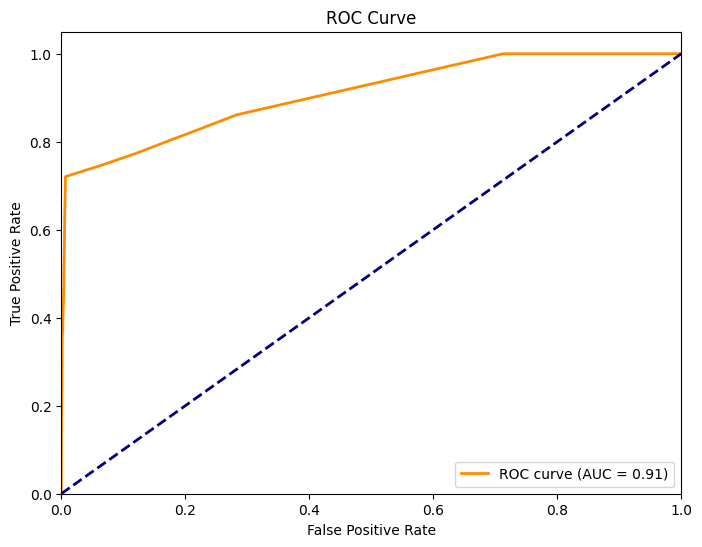

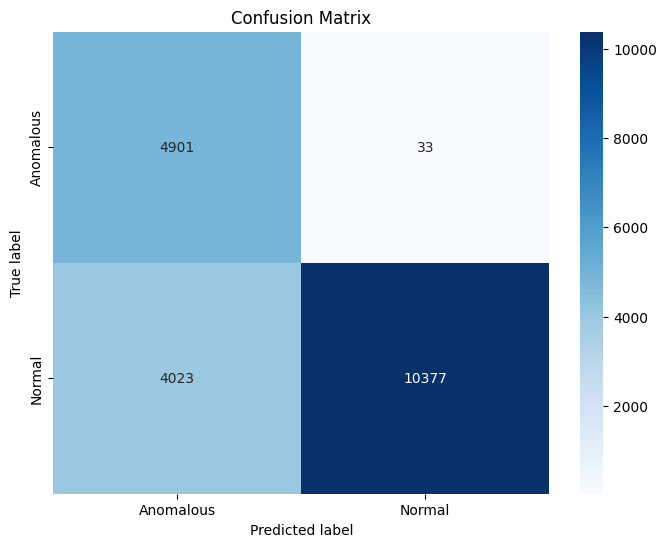

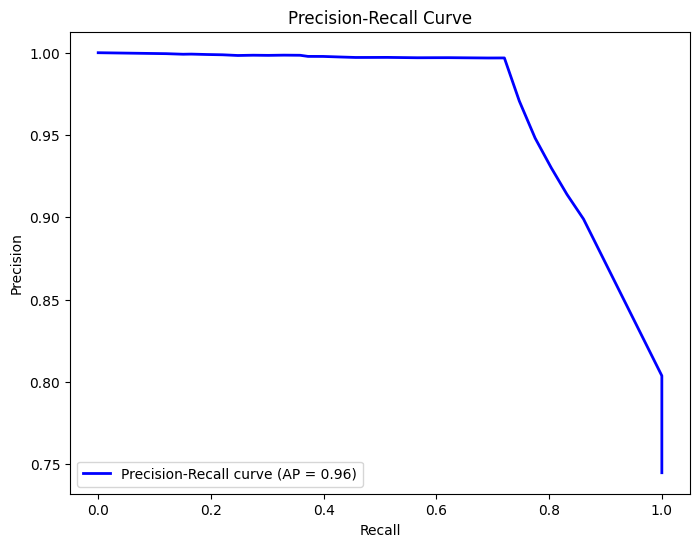

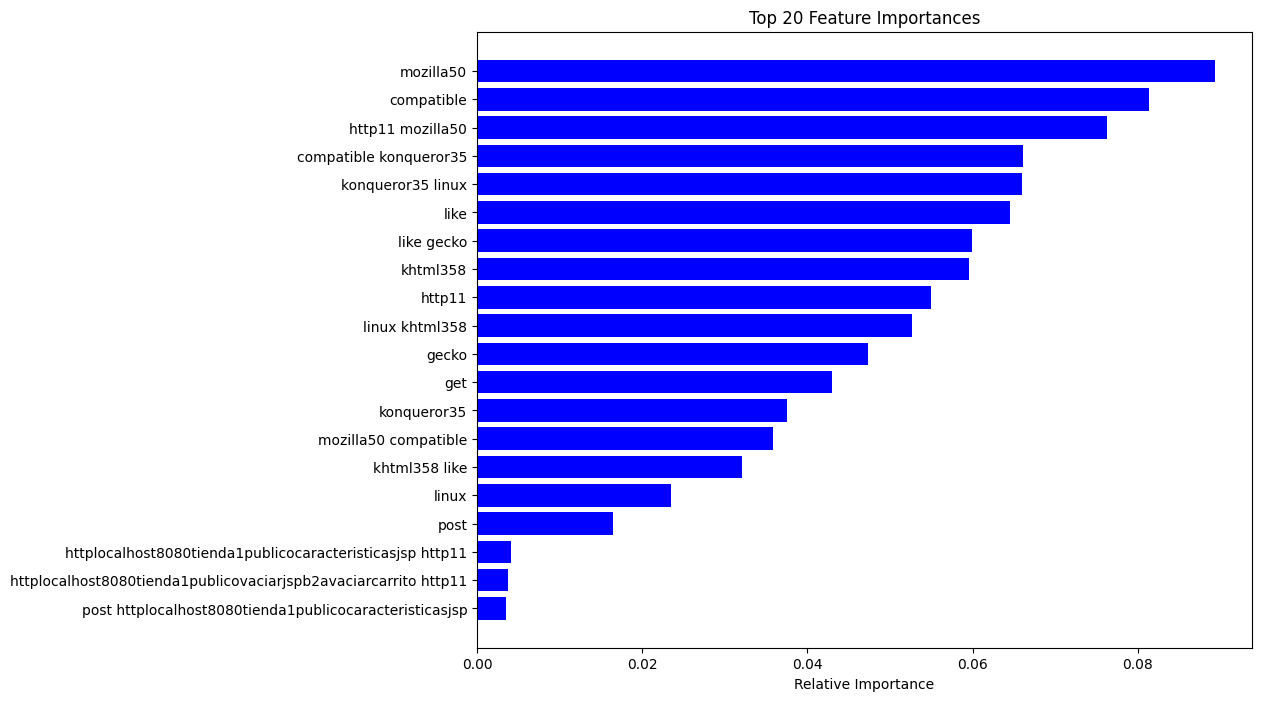


Example prediction for 'GET http://example.com/login.php HTTP/1.1 Mozilla/5.0':
Predicted class: Anomalous
Probability: 0.10


In [16]:

def main():
    # Load and prepare data
    X, y, le = load_and_prepare_data('http_requests_all.csv')
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train the model
    print("Training model...")
    model = train_model(X_train, y_train)
    
    # Evaluate the model with visualizations
    print("\nEvaluating model...")
    evaluate_model(model, X_test, y_test, le)
    
    # Example prediction
    example_request = "GET http://example.com/login.php HTTP/1.1 Mozilla/5.0"
    print(f"\nExample prediction for '{example_request}':")
    pred = model.predict([example_request])
    print(f"Predicted class: {le.inverse_transform(pred)[0]}")
    print(f"Probability: {model.predict_proba([example_request])[0][1]:.2f}")

if __name__ == "__main__":
    main()

### Remember to create requirements.txt
```bash
pip install pipreqsnb
import pipreqsnb
pipreqsnb csic-2010-https-attacks-classifier.ipynb
```